In [1]:
from scipy.io import wavfile
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In the wave file there is recording of baseband data from SDRSharp. It consists of [I and Q components from quadrature sampling](https://pysdr.org/content/sampling.html). 

In [2]:
wav_fname = 'SDRSharp_20220323_181018Z_106900000Hz_IQ.wav'
Fs, data = wavfile.read(wav_fname)

First, let's draw IQ data for the first 1 ms.

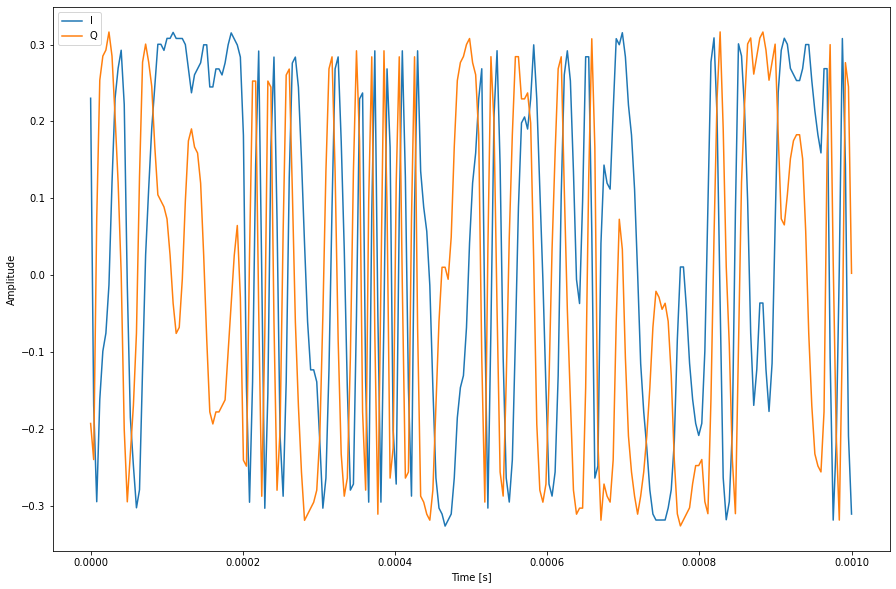

In [3]:
timespan = 0.001
N = int(timespan*Fs)
x = data[:N,:]

time = np.linspace(0, timespan, N)
plt.figure(figsize=(15, 10))
plt.plot(time, x[:, 0], label="I")
plt.plot(time, x[:, 1], label="Q")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

That looks pretty random.

How about *power spectral density* for the first 10 ms?

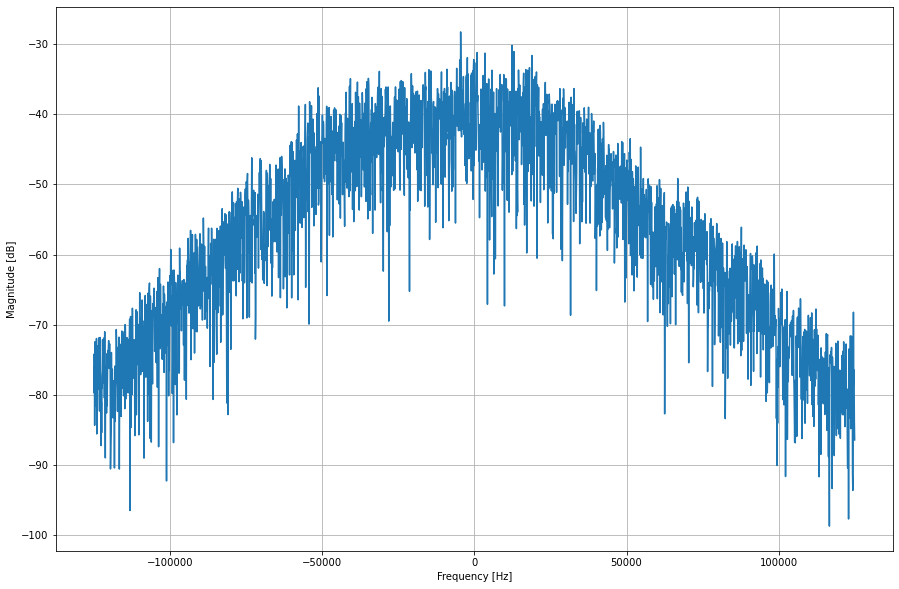

In [4]:
timespan = 0.01
N = int(timespan*Fs)
x = data[:N,:]

r = x[:,0] + 1j*x[:,1]

PSD = (np.abs(np.fft.fft(r))/N)**2
PSD_log = 10.0*np.log10(PSD)
PSD_shifted = np.fft.fftshift(PSD_log)

f = np.arange(Fs/-2.0, Fs/2.0, Fs/N) # start, stop, step

plt.figure(figsize=(15, 10))
plt.plot(f, PSD_shifted)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.show()

That's better. We can see that the signal is conveniently concentrated around 0Hz frequency offset. Offset -- because it's tuned to some unknown frequency by a SDR hardware.

Let's see how frequency spectrum changes over time for the first 200 ms.

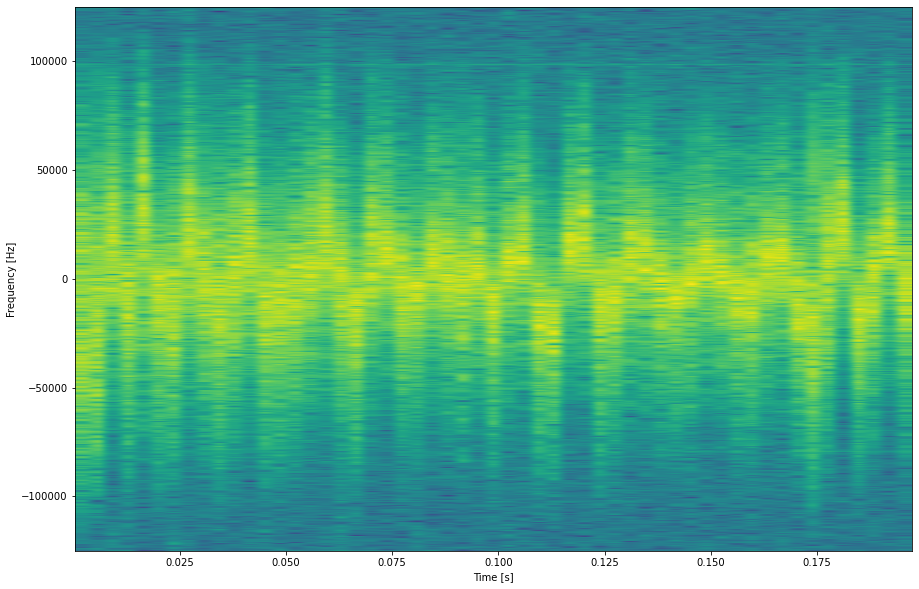

In [5]:
timespan = 0.2
N = int(timespan*Fs)
x1 = data[:N,0] + 1j*data[:N,1]

plt.figure(figsize=(15, 10))
plt.specgram(x1, NFFT=1024, Fs=Fs)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

It shifts up and down! That looks like FM transmission.

We can also plot the constellation (e.g. for 10 ms worth of samples), which should have the circular pattern typical of an FM signal:

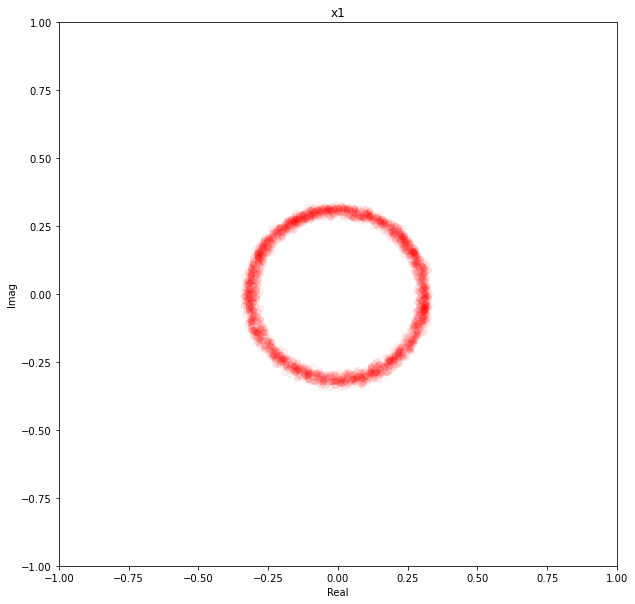

In [6]:
timespan = 0.01
N = int(timespan*Fs)
x1 = data[:N,0] + 1j*data[:N,1]

# Plot the constellation of x1.  What does it look like?
plt.figure(figsize=(10, 10))
plt.scatter(np.real(x1), np.imag(x1), color="red", alpha=0.05)  
plt.title("x1")  
plt.xlabel("Real")  
plt.xlim(-1,1)  
plt.ylabel("Imag")  
plt.ylim(-1,1)
plt.show()

To demodulate FM signal frequency discriminator is used. It converts frequency changes to amplitude changes. One of the possible frequency discriminators is a polar discriminator.

A polar discriminator measures the phase difference between consecutive samples of a complex-sampled FM signal. More specifically, it takes successive complex-valued samples and multiplies the new sample by the conjugate of the old sample. Then it takes the angle of this complex value. This turns out to be the instantaneous frequency of the sampled FM signal.

In [30]:
N = data.shape[0]
timespan = N/Fs
x1 = data[:N,0] + 1j*data[:N,1]

y2 = x1[1:] * np.conj(x1[:-1])  
x2 = np.angle(y2)  

Note: x2 is now an array of real, not complex, values

As a result, the PSDs will now be plotted single-sided by default (since a real signal has a symmetric spectrum)

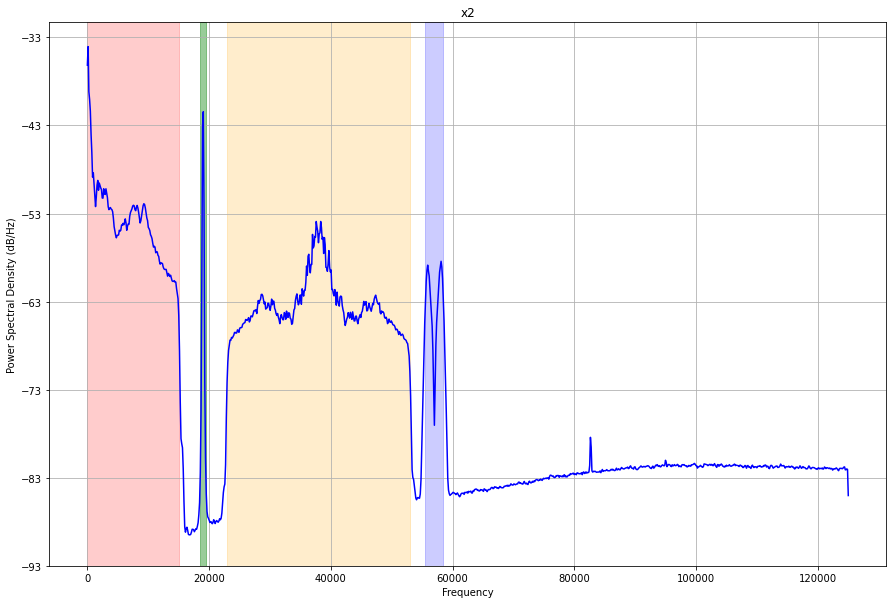

In [31]:
plt.figure(figsize=(15, 10))
plt.psd(x2, NFFT=2048, Fs=Fs, color="blue")  
plt.title("x2")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  

*Different parts of the radio broadcast signal are clearly visible in this image. The mono audio signal on the far left is of most interest to us. We can also see the pilot tone at 19 kHz, which is used to help decode the stereo audio centered at 38 kHz. To the left of that, we can see digital data carried at 57 kHz - this often includes time, station identification and program information.*

We will use [de-emphasis filter](https://en.wikipedia.org/wiki/FM_broadcasting#Pre-emphasis_and_de-emphasis)
to get mono audio signal.

In [36]:
d = Fs * 75e-6   # Calculate the # of samples to hit the -3dB point
xx = np.exp(-1/d)   # Calculate the decay between each sample
b = [1-xx]          # Create the filter coefficients
a = [1,-xx]
x3 = signal.lfilter(b,a,x2)

Let's downsimple it to audio frequency.

In [46]:
audio_freq = 44100.0
dec_audio = int(Fs/audio_freq)
Fs_audio = Fs / dec_audio

x4 = signal.decimate(x3, dec_audio)

And scale it up to 80%. Write to file.

In [44]:
scale = 0.8 * 32768 / np.max(np.abs(x4))
x5 = x4 * scale

wavfile.write("mono.wav", 44100, x5.astype(np.int16))

Here it is.

In [45]:
import IPython

IPython.display.Audio("mono.wav")